In [90]:
%matplotlib inline
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, DenseNet169
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    RandRotate90,
    Resize,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.7.0
Numpy version: 1.18.1
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.3.1
Tensorboard version: 2.1.0
gdown version: 3.10.1
TorchVision version: 0.10.0+cu102
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpbqiapeoz


In [6]:
from dataframe import *

In [7]:
'''Instantiate the dataset'''
bh_folder = '/workspace/0728tot/BreaKHis_v1/'
df = make_breakhis_df(bh_folder)

In [8]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

In [9]:
import random
import itertools
import math

def get_splits():
    DC = ['10926' ,'11031', '11520' ,'11951', '12312', '13993' ,'14015' ,'14926','14946', 
          '15572', '15696' ,'15792', '16188' ,'16336', '16448', '16601', '16716','16875',
          '17614' ,'17901' ,'17915', '18650' ,'20629', '20636', '2523', '2773','2980',
          '2985' ,'3909', '4364' ,'4372' ,'5287', '5694' ,'5695', '6241' ,'8168','9461']
    F  = ['14134','14134E','21998CD' ,'21998EF' ,'23060AB', '23060CD' ,'23222AB', '25197', '29960AB' ,'9133']
    MC = ['10147', '12773', '13413', '13418DE', '16456', '18842', '18842D', '19979', '19979C']
    TA = ['13200', '15275', '16184', '16184CD', '19854C' ,'21978AB' ,'3411F']
    PC = ['12465', '15687B' ,'15704', '190EF' ,'19440', '9146']
    LC = ['12204' , '15570', '15570C', '16196']
    A  = ['22549AB' ,'22549CD', '22549G', '29960CD']
    PT = ['21998AB' ,'22704', '29315EF']
    benign=F+TA+A+PT
    malign=DC+MC+PC+LC
    
    random.shuffle(benign)
    random.shuffle(malign)
    tl=[benign,malign]
    train_split=[]
    val_split=[]
    test_split=[]
    for i in range(1,6):
        train=[]
        test=[]
        val=[]
        for x in tl:
            lenn=len(x)
            first=math.floor(0.2*lenn*(i-1))
            mid=math.floor(0.2*lenn*i)
            if first==0:
                inp=x[mid:lenn]
                for y in inp:
                    train.append(y)
            elif mid==lenn:
                inp=x[0:first]
                for y in inp:
                    train.append(y)
            else:
                inp=x[0:first]
                for y in inp:
                    train.append(y)
                inp=x[mid:lenn]
                for y in inp:
                    train.append(y)
            inp=x[first:mid]
            inp1,inp2=split_list(inp)
            for y in inp1:
                test.append(y)
            for y in inp2:
                val.append(y)
        #train = list(itertools.chain.from_iterable(train))
        #test = list(itertools.chain.from_iterable(test))
        
        train_split.append(train), val_split.append(val), test_split.append(test)
        
    return train_split, val_split, test_split,tl

In [10]:
bh_folder = '/workspace/0728tot/BreaKHis_v1/'
df = make_breakhis_df(bh_folder)

In [108]:
train_split, val_split, test_split,tl = get_splits()

In [109]:
df_mag=df[df.magnification==40]

In [110]:
df_train = df_mag[(df_mag.slide_id.isin(train_split[0]))]
df_val = df_mag[(df_mag.slide_id.isin(val_split[0]))]
df_test = df_mag[(df_mag.slide_id.isin(test_split[0]))]

In [70]:
df_mag

,relpath,filename,biopsy_procedure,tumor_class,tumor_type,year,slide_id,magnification,seq,fullpath
0,histology_slides/breast/malignant/SOB/ductal_c...,SOB_M_DC-14-11031-100-006.png,SOB,M,DC,14,11031,100,6,/workspace/0728tot/BreaKHis_v1/histology_slide...
1,histology_slides/breast/malignant/SOB/ductal_c...,SOB_M_DC-14-11031-100-003.png,SOB,M,DC,14,11031,100,3,/workspace/0728tot/BreaKHis_v1/histology_slide...
2,histology_slides/breast/malignant/SOB/ductal_c...,SOB_M_DC-14-11031-100-010.png,SOB,M,DC,14,11031,100,10,/workspace/0728tot/BreaKHis_v1/histology_slide...
3,histology_slides/breast/malignant/SOB/ductal_c...,SOB_M_DC-14-11031-100-002.png,SOB,M,DC,14,11031,100,2,/workspace/0728tot/BreaKHis_v1/histology_slide...
4,histology_slides/breast/malignant/SOB/ductal_c...,SOB_M_DC-14-11031-100-007.png,SOB,M,DC,14,11031,100,7,/workspace/0728tot/BreaKHis_v1/histology_slide...
...,...,...,...,...,...,...,...,...,...,...
7865,histology_slides/breast/benign/SOB/tubular_ade...,SOB_B_TA-14-15275-100-007.png,SOB,B,TA,14,15275,100,7,/workspace/0728tot/BreaKHis_v1/histology_slide...
7866,histology_slides/breast/benign/SOB/tubular_ade...,SOB_B_TA-14-15275-100-002.png,SOB,B,TA,14,15275,100,2,/workspace/0728tot/BreaKHis_v1/histology_slide...
7867,histology_slides/breast/benign/SOB/tubular_ade...,SOB_B_TA-14-15275-100-011.png,SOB,B,TA,14,15275,100,11,/workspace/0728tot/BreaKHis_v1/histology_slide...
7868,histology_slides/breast/benign/SOB/tubular_ade...,SOB_B_TA-14-15275-100-004.png,SOB,B,TA,14,15275,100,4,/workspace/0728tot/BreaKHis_v1/histology_slide...


In [111]:
train_x = df_train.fullpath.to_list()
train_y = df_train.tumor_class.to_list()
test_x = df_test.fullpath.to_list()
test_y = df_test.tumor_class.to_list()
val_x = df_val.fullpath.to_list()
val_y = df_val.tumor_class.to_list()

In [112]:
len(train_x)==len(train_y)

True

In [113]:
len(test_x)==len(test_y)

True

In [114]:
num_class=2

In [115]:
# train_transforms = Compose(
#     [
#         LoadImage(image_only=True),
#         AddChannel(),
#         ScaleIntensity(),
#         RandRotate90(prob=0.5),
#         RandFlip(spatial_axis=0, prob=0.5),
#         Resize(spatial_size=(224,224,-1)),
#         EnsureType(),
#     ]
# )

# val_transforms = Compose(
#     [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
# y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_class)])

In [116]:
splt = ['train','test','val']
tumortypes = ['M','B']
for s in splt:
    for t in tumortypes:
        shutil.rmtree(f'/workspace/0728tot/binaryclass/{s}/{t}', ignore_errors=True)
        os.makedirs(f'/workspace/0728tot/binaryclass/{s}/{t}')

In [117]:
for t in tumortypes:
    df_train[df_train.tumor_class == t].apply(lambda x: shutil.copyfile(x.fullpath, f'/workspace/0728tot/binaryclass/train/{t}/{x.filename}'), axis = 1)
    df_test[df_test.tumor_class == t].apply(lambda x: shutil.copyfile(x.fullpath, f'/workspace/0728tot/binaryclass/test/{t}/{x.filename}'), axis = 1)
    df_val[df_val.tumor_class == t].apply(lambda x: shutil.copyfile(x.fullpath, f'/workspace/0728tot/binaryclass/val/{t}/{x.filename}'), axis = 1)

In [118]:
train_directory='/workspace/0728tot/binaryclass/train/'
test_directory='/workspace/0728tot/binaryclass/test/'
val_directory='/workspace/0728tot/binaryclass/val/'

In [119]:
from torchvision import datasets, transforms

In [120]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256), #scale=(0.8, 1.0))
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [121]:
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms['test']),
}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])
val_data_size = len(data['val'])

# batch size
bs=32

# Create iterators for the Data loaded using DataLoader module
train_data = torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data = torch.utils.data.DataLoader(data['test'], batch_size=bs)
val_data = torch.utils.data.DataLoader(data['val'], batch_size=bs)

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}


In [122]:
train_loader = train_data 
test_loader = test_data
val_loader = val_data

In [39]:
# class BreakHisDataset(torch.utils.data.Dataset):
#     def __init__(self, image_files, labels, transforms):
#         self.image_files = image_files
#         self.labels = labels
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, index):
#         return self.transforms(self.image_files[index]), self.labels[index]


# train_ds = BreakHisDataset(train_x, train_y, train_transforms)
# train_loader = torch.utils.data.DataLoader(
#     train_ds, batch_size=16, shuffle=True)

# val_ds = BreakHisDataset(val_x, val_y, val_transforms)
# val_loader = torch.utils.data.DataLoader(
#     val_ds, batch_size=16)

# test_ds = BreakHisDataset(test_x, test_y, val_transforms)
# test_loader = torch.utils.data.DataLoader(
#     test_ds, batch_size=16)

In [123]:
num_classes=2

AttributeError: 'DenseNet169' object has no attribute 'layers'

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet169(spatial_dims=2, in_channels=3,
                    out_channels=num_class, dropout_prob=0.1).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [125]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "40best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/100
1/51, train_loss: 0.8621
2/51, train_loss: 0.8351
3/51, train_loss: 0.7796
4/51, train_loss: 0.8423
5/51, train_loss: 0.8345
6/51, train_loss: 0.6706
7/51, train_loss: 0.8036
8/51, train_loss: 0.8545
9/51, train_loss: 0.6855
10/51, train_loss: 0.7427
11/51, train_loss: 0.7847
12/51, train_loss: 0.7024
13/51, train_loss: 0.7392
14/51, train_loss: 0.7389
15/51, train_loss: 0.7434
16/51, train_loss: 0.7949
17/51, train_loss: 0.8365
18/51, train_loss: 0.7888
19/51, train_loss: 0.7392
20/51, train_loss: 0.6826
21/51, train_loss: 0.7983
22/51, train_loss: 0.7476
23/51, train_loss: 0.6980
24/51, train_loss: 0.7874
25/51, train_loss: 0.7179
26/51, train_loss: 0.7945
27/51, train_loss: 0.7755
28/51, train_loss: 0.7545
29/51, train_loss: 0.6933
30/51, train_loss: 0.7284
31/51, train_loss: 0.6774
32/51, train_loss: 0.6783
33/51, train_loss: 0.6955
34/51, train_loss: 0.7421
35/51, train_loss: 0.6764
36/51, train_loss: 0.7055
37/51, train_loss: 0.6749
38/51, train_loss: 0.672

43/51, train_loss: 0.3020
44/51, train_loss: 0.6035
45/51, train_loss: 0.3977
46/51, train_loss: 0.3498
47/51, train_loss: 0.4563
48/51, train_loss: 0.6102
49/51, train_loss: 0.4364
epoch 6 average loss: 0.4529
current epoch: 6 current AUC: 0.6892 current accuracy: 0.7461 best AUC: 0.7140 at epoch: 4
----------
epoch 7/100
1/51, train_loss: 0.5462
2/51, train_loss: 0.3687
3/51, train_loss: 0.4844
4/51, train_loss: 0.5139
5/51, train_loss: 0.3559
6/51, train_loss: 0.5727
7/51, train_loss: 0.6168
8/51, train_loss: 0.3510
9/51, train_loss: 0.4461
10/51, train_loss: 0.4126
11/51, train_loss: 0.4623
12/51, train_loss: 0.6086
13/51, train_loss: 0.3558
14/51, train_loss: 0.5147
15/51, train_loss: 0.3983
16/51, train_loss: 0.4836
17/51, train_loss: 0.3338
18/51, train_loss: 0.3122
19/51, train_loss: 0.4665
20/51, train_loss: 0.4041
21/51, train_loss: 0.3663
22/51, train_loss: 0.4528
23/51, train_loss: 0.6088
24/51, train_loss: 0.3076
25/51, train_loss: 0.4800
26/51, train_loss: 0.3815
27/51, t

33/51, train_loss: 0.4116
34/51, train_loss: 0.5415
35/51, train_loss: 0.3695
36/51, train_loss: 0.3866
37/51, train_loss: 0.4082
38/51, train_loss: 0.2975
39/51, train_loss: 0.5560
40/51, train_loss: 0.5938
41/51, train_loss: 0.3534
42/51, train_loss: 0.3208
43/51, train_loss: 0.5795
44/51, train_loss: 0.6313
45/51, train_loss: 0.5634
46/51, train_loss: 0.4470
47/51, train_loss: 0.3370
48/51, train_loss: 0.4189
49/51, train_loss: 0.5709
epoch 12 average loss: 0.4404
saved new best metric model
current epoch: 12 current AUC: 0.7438 current accuracy: 0.7824 best AUC: 0.7438 at epoch: 12
----------
epoch 13/100
1/51, train_loss: 0.3472
2/51, train_loss: 0.4325
3/51, train_loss: 0.2806
4/51, train_loss: 0.5032
5/51, train_loss: 0.5274
6/51, train_loss: 0.3880
7/51, train_loss: 0.3482
8/51, train_loss: 0.3978
9/51, train_loss: 0.5397
10/51, train_loss: 0.4748
11/51, train_loss: 0.3302
12/51, train_loss: 0.3861
13/51, train_loss: 0.3507
14/51, train_loss: 0.4095
15/51, train_loss: 0.5491
16

21/51, train_loss: 0.3821
22/51, train_loss: 0.5228
23/51, train_loss: 0.4535
24/51, train_loss: 0.3867
25/51, train_loss: 0.4009
26/51, train_loss: 0.3969
27/51, train_loss: 0.2878
28/51, train_loss: 0.3043
29/51, train_loss: 0.4186
30/51, train_loss: 0.4266
31/51, train_loss: 0.4528
32/51, train_loss: 0.3114
33/51, train_loss: 0.3704
34/51, train_loss: 0.3773
35/51, train_loss: 0.3983
36/51, train_loss: 0.5021
37/51, train_loss: 0.4382
38/51, train_loss: 0.3807
39/51, train_loss: 0.2851
40/51, train_loss: 0.2956
41/51, train_loss: 0.2721
42/51, train_loss: 0.3009
43/51, train_loss: 0.4506
44/51, train_loss: 0.4309
45/51, train_loss: 0.3861
46/51, train_loss: 0.5413
47/51, train_loss: 0.3589
48/51, train_loss: 0.3911
49/51, train_loss: 0.2879
epoch 18 average loss: 0.3979
current epoch: 18 current AUC: 0.7445 current accuracy: 0.7461 best AUC: 0.7683 at epoch: 16
----------
epoch 19/100
1/51, train_loss: 0.3822
2/51, train_loss: 0.3542
3/51, train_loss: 0.4865
4/51, train_loss: 0.4101

9/51, train_loss: 0.5166
10/51, train_loss: 0.3881
11/51, train_loss: 0.3343
12/51, train_loss: 0.2327
13/51, train_loss: 0.3431
14/51, train_loss: 0.2738
15/51, train_loss: 0.3525
16/51, train_loss: 0.5812
17/51, train_loss: 0.2261
18/51, train_loss: 0.2496
19/51, train_loss: 0.3265
20/51, train_loss: 0.5498
21/51, train_loss: 0.3106
22/51, train_loss: 0.2573
23/51, train_loss: 0.3559
24/51, train_loss: 0.4130
25/51, train_loss: 0.3671
26/51, train_loss: 0.3337
27/51, train_loss: 0.3544
28/51, train_loss: 0.2807
29/51, train_loss: 0.4214
30/51, train_loss: 0.3019
31/51, train_loss: 0.5051
32/51, train_loss: 0.3306
33/51, train_loss: 0.2691
34/51, train_loss: 0.6649
35/51, train_loss: 0.3906
36/51, train_loss: 0.3502
37/51, train_loss: 0.3470
38/51, train_loss: 0.4674
39/51, train_loss: 0.3909
40/51, train_loss: 0.3642
41/51, train_loss: 0.3731
42/51, train_loss: 0.5335
43/51, train_loss: 0.3249
44/51, train_loss: 0.3809
45/51, train_loss: 0.3450
46/51, train_loss: 0.3721
47/51, train_

1/51, train_loss: 0.2835
2/51, train_loss: 0.4069
3/51, train_loss: 0.3166
4/51, train_loss: 0.5095
5/51, train_loss: 0.2883
6/51, train_loss: 0.3503
7/51, train_loss: 0.4950
8/51, train_loss: 0.2193
9/51, train_loss: 0.2742
10/51, train_loss: 0.5021
11/51, train_loss: 0.2738
12/51, train_loss: 0.2644
13/51, train_loss: 0.4172
14/51, train_loss: 0.3032
15/51, train_loss: 0.2911
16/51, train_loss: 0.2514
17/51, train_loss: 0.6683
18/51, train_loss: 0.3648
19/51, train_loss: 0.5014
20/51, train_loss: 0.4584
21/51, train_loss: 0.4217
22/51, train_loss: 0.2736
23/51, train_loss: 0.3394
24/51, train_loss: 0.4256
25/51, train_loss: 0.3240
26/51, train_loss: 0.3363
27/51, train_loss: 0.4491
28/51, train_loss: 0.4034
29/51, train_loss: 0.3872
30/51, train_loss: 0.4729
31/51, train_loss: 0.2942
32/51, train_loss: 0.4567
33/51, train_loss: 0.3330
34/51, train_loss: 0.3824
35/51, train_loss: 0.4499
36/51, train_loss: 0.4618
37/51, train_loss: 0.3683
38/51, train_loss: 0.5176
39/51, train_loss: 0.

45/51, train_loss: 0.3113
46/51, train_loss: 0.2137
47/51, train_loss: 0.3174
48/51, train_loss: 0.3027
49/51, train_loss: 0.3972
epoch 35 average loss: 0.3623
current epoch: 35 current AUC: 0.7747 current accuracy: 0.7358 best AUC: 0.7954 at epoch: 22
----------
epoch 36/100
1/51, train_loss: 0.3457
2/51, train_loss: 0.2403
3/51, train_loss: 0.3064
4/51, train_loss: 0.2988
5/51, train_loss: 0.3258
6/51, train_loss: 0.1572
7/51, train_loss: 0.4151
8/51, train_loss: 0.3953
9/51, train_loss: 0.2456
10/51, train_loss: 0.3555
11/51, train_loss: 0.3568
12/51, train_loss: 0.3415
13/51, train_loss: 0.3146
14/51, train_loss: 0.1957
15/51, train_loss: 0.3027
16/51, train_loss: 0.3961
17/51, train_loss: 0.4355
18/51, train_loss: 0.2761
19/51, train_loss: 0.4806
20/51, train_loss: 0.4930
21/51, train_loss: 0.3051
22/51, train_loss: 0.3011
23/51, train_loss: 0.3652
24/51, train_loss: 0.1577
25/51, train_loss: 0.1959
26/51, train_loss: 0.3545
27/51, train_loss: 0.2206
28/51, train_loss: 0.2056
29/5

35/51, train_loss: 0.2250
36/51, train_loss: 0.4595
37/51, train_loss: 0.4048
38/51, train_loss: 0.3134
39/51, train_loss: 0.2504
40/51, train_loss: 0.3913
41/51, train_loss: 0.3889
42/51, train_loss: 0.3218
43/51, train_loss: 0.4649
44/51, train_loss: 0.3738
45/51, train_loss: 0.4301
46/51, train_loss: 0.3591
47/51, train_loss: 0.3001
48/51, train_loss: 0.4289
49/51, train_loss: 0.3402
epoch 41 average loss: 0.3276
current epoch: 41 current AUC: 0.7711 current accuracy: 0.7150 best AUC: 0.7954 at epoch: 22
----------
epoch 42/100
1/51, train_loss: 0.3037
2/51, train_loss: 0.3005
3/51, train_loss: 0.3698
4/51, train_loss: 0.3713
5/51, train_loss: 0.4654
6/51, train_loss: 0.3469
7/51, train_loss: 0.2524
8/51, train_loss: 0.2517
9/51, train_loss: 0.3326
10/51, train_loss: 0.3888
11/51, train_loss: 0.5253
12/51, train_loss: 0.4625
13/51, train_loss: 0.3370
14/51, train_loss: 0.4055
15/51, train_loss: 0.3983
16/51, train_loss: 0.3638
17/51, train_loss: 0.5861
18/51, train_loss: 0.3950
19/5

25/51, train_loss: 0.5247
26/51, train_loss: 0.2667
27/51, train_loss: 0.1922
28/51, train_loss: 0.2234
29/51, train_loss: 0.3374
30/51, train_loss: 0.3783
31/51, train_loss: 0.2730
32/51, train_loss: 0.2869
33/51, train_loss: 0.3177
34/51, train_loss: 0.2343
35/51, train_loss: 0.3107
36/51, train_loss: 0.1616
37/51, train_loss: 0.2758
38/51, train_loss: 0.3649
39/51, train_loss: 0.3513
40/51, train_loss: 0.2573
41/51, train_loss: 0.4919
42/51, train_loss: 0.2441
43/51, train_loss: 0.2743
44/51, train_loss: 0.3010
45/51, train_loss: 0.4602
46/51, train_loss: 0.3860
47/51, train_loss: 0.4217
48/51, train_loss: 0.2656
49/51, train_loss: 0.1585
epoch 47 average loss: 0.3291
current epoch: 47 current AUC: 0.7551 current accuracy: 0.7202 best AUC: 0.7954 at epoch: 22
----------
epoch 48/100
1/51, train_loss: 0.3372
2/51, train_loss: 0.3550
3/51, train_loss: 0.2990
4/51, train_loss: 0.5216
5/51, train_loss: 0.2633
6/51, train_loss: 0.3785
7/51, train_loss: 0.2892
8/51, train_loss: 0.3515
9/5

15/51, train_loss: 0.5786
16/51, train_loss: 0.3028
17/51, train_loss: 0.3123
18/51, train_loss: 0.1935
19/51, train_loss: 0.2965
20/51, train_loss: 0.3172
21/51, train_loss: 0.3312
22/51, train_loss: 0.2904
23/51, train_loss: 0.2825
24/51, train_loss: 0.3575
25/51, train_loss: 0.2176
26/51, train_loss: 0.3231
27/51, train_loss: 0.2815
28/51, train_loss: 0.3125
29/51, train_loss: 0.4975
30/51, train_loss: 0.3912
31/51, train_loss: 0.3606
32/51, train_loss: 0.2596
33/51, train_loss: 0.1833
34/51, train_loss: 0.3722
35/51, train_loss: 0.2525
36/51, train_loss: 0.4765
37/51, train_loss: 0.3131
38/51, train_loss: 0.2745
39/51, train_loss: 0.3692
40/51, train_loss: 0.2968
41/51, train_loss: 0.3521
42/51, train_loss: 0.3063
43/51, train_loss: 0.1959
44/51, train_loss: 0.2657
45/51, train_loss: 0.2630
46/51, train_loss: 0.2191
47/51, train_loss: 0.4852
48/51, train_loss: 0.3344
49/51, train_loss: 0.2396
epoch 53 average loss: 0.3100
current epoch: 53 current AUC: 0.7820 current accuracy: 0.73

5/51, train_loss: 0.4890
6/51, train_loss: 0.3921
7/51, train_loss: 0.2358
8/51, train_loss: 0.3167
9/51, train_loss: 0.2702
10/51, train_loss: 0.2330
11/51, train_loss: 0.3054
12/51, train_loss: 0.3502
13/51, train_loss: 0.2963
14/51, train_loss: 0.4151
15/51, train_loss: 0.2750
16/51, train_loss: 0.3570
17/51, train_loss: 0.2277
18/51, train_loss: 0.2258
19/51, train_loss: 0.3407
20/51, train_loss: 0.2823
21/51, train_loss: 0.3583
22/51, train_loss: 0.1717
23/51, train_loss: 0.1929
24/51, train_loss: 0.2913
25/51, train_loss: 0.1638
26/51, train_loss: 0.1862
27/51, train_loss: 0.3620
28/51, train_loss: 0.2077
29/51, train_loss: 0.3075
30/51, train_loss: 0.1386
31/51, train_loss: 0.2622
32/51, train_loss: 0.3031
33/51, train_loss: 0.3261
34/51, train_loss: 0.3957
35/51, train_loss: 0.2736
36/51, train_loss: 0.6039
37/51, train_loss: 0.4101
38/51, train_loss: 0.3566
39/51, train_loss: 0.2502
40/51, train_loss: 0.2719
41/51, train_loss: 0.4560
42/51, train_loss: 0.2573
43/51, train_loss

49/51, train_loss: 0.3139
epoch 64 average loss: 0.3013
current epoch: 64 current AUC: 0.7839 current accuracy: 0.7306 best AUC: 0.7954 at epoch: 22
----------
epoch 65/100
1/51, train_loss: 0.2258
2/51, train_loss: 0.4266
3/51, train_loss: 0.2128
4/51, train_loss: 0.3459
5/51, train_loss: 0.2235
6/51, train_loss: 0.1733
7/51, train_loss: 0.3989
8/51, train_loss: 0.3805
9/51, train_loss: 0.3051
10/51, train_loss: 0.3066
11/51, train_loss: 0.3251
12/51, train_loss: 0.2782
13/51, train_loss: 0.1477
14/51, train_loss: 0.3893
15/51, train_loss: 0.2408
16/51, train_loss: 0.5067
17/51, train_loss: 0.2638
18/51, train_loss: 0.4174
19/51, train_loss: 0.2149
20/51, train_loss: 0.4261
21/51, train_loss: 0.4467
22/51, train_loss: 0.3004
23/51, train_loss: 0.3506
24/51, train_loss: 0.2816
25/51, train_loss: 0.3353
26/51, train_loss: 0.2892
27/51, train_loss: 0.4360
28/51, train_loss: 0.1382
29/51, train_loss: 0.1327
30/51, train_loss: 0.3605
31/51, train_loss: 0.1562
32/51, train_loss: 0.3055
33/5

37/51, train_loss: 0.2114
38/51, train_loss: 0.2855
39/51, train_loss: 0.1289
40/51, train_loss: 0.2636
41/51, train_loss: 0.2175
42/51, train_loss: 0.2973
43/51, train_loss: 0.2819
44/51, train_loss: 0.1407
45/51, train_loss: 0.3151
46/51, train_loss: 0.4120
47/51, train_loss: 0.3882
48/51, train_loss: 0.3507
49/51, train_loss: 0.4514
epoch 70 average loss: 0.2890
current epoch: 70 current AUC: 0.7946 current accuracy: 0.7358 best AUC: 0.7988 at epoch: 69
----------
epoch 71/100
1/51, train_loss: 0.4381
2/51, train_loss: 0.1761
3/51, train_loss: 0.4082
4/51, train_loss: 0.4499
5/51, train_loss: 0.1666
6/51, train_loss: 0.2794
7/51, train_loss: 0.3134
8/51, train_loss: 0.1695
9/51, train_loss: 0.3840
10/51, train_loss: 0.2729
11/51, train_loss: 0.3471
12/51, train_loss: 0.1548
13/51, train_loss: 0.2647
14/51, train_loss: 0.3298
15/51, train_loss: 0.4005
16/51, train_loss: 0.1766
17/51, train_loss: 0.2296
18/51, train_loss: 0.1973
19/51, train_loss: 0.2256
20/51, train_loss: 0.1931
21/5

25/51, train_loss: 0.3112
26/51, train_loss: 0.4168
27/51, train_loss: 0.2594
28/51, train_loss: 0.3583
29/51, train_loss: 0.5327
30/51, train_loss: 0.4238
31/51, train_loss: 0.4143
32/51, train_loss: 0.1728
33/51, train_loss: 0.3485
34/51, train_loss: 0.5766
35/51, train_loss: 0.2918
36/51, train_loss: 0.2474
37/51, train_loss: 0.2341
38/51, train_loss: 0.2772
39/51, train_loss: 0.2725
40/51, train_loss: 0.2910
41/51, train_loss: 0.3863
42/51, train_loss: 0.4875
43/51, train_loss: 0.4005
44/51, train_loss: 0.2310
45/51, train_loss: 0.1896
46/51, train_loss: 0.2768
47/51, train_loss: 0.1413
48/51, train_loss: 0.5244
49/51, train_loss: 0.2711
epoch 76 average loss: 0.3037
current epoch: 76 current AUC: 0.8007 current accuracy: 0.7461 best AUC: 0.8077 at epoch: 74
----------
epoch 77/100
1/51, train_loss: 0.3090
2/51, train_loss: 0.5278
3/51, train_loss: 0.3245
4/51, train_loss: 0.3283
5/51, train_loss: 0.2310
6/51, train_loss: 0.2734
7/51, train_loss: 0.1854
8/51, train_loss: 0.2615
9/5

14/51, train_loss: 0.1790
15/51, train_loss: 0.4216
16/51, train_loss: 0.2774
17/51, train_loss: 0.2478
18/51, train_loss: 0.2115
19/51, train_loss: 0.2049
20/51, train_loss: 0.2637
21/51, train_loss: 0.2077
22/51, train_loss: 0.4858
23/51, train_loss: 0.4233
24/51, train_loss: 0.4215
25/51, train_loss: 0.2884
26/51, train_loss: 0.3702
27/51, train_loss: 0.2384
28/51, train_loss: 0.1741
29/51, train_loss: 0.4692
30/51, train_loss: 0.2576
31/51, train_loss: 0.0941
32/51, train_loss: 0.2454
33/51, train_loss: 0.1966
34/51, train_loss: 0.2113
35/51, train_loss: 0.2845
36/51, train_loss: 0.1626
37/51, train_loss: 0.3555
38/51, train_loss: 0.2372
39/51, train_loss: 0.2407
40/51, train_loss: 0.1830
41/51, train_loss: 0.4864
42/51, train_loss: 0.3102
43/51, train_loss: 0.1839
44/51, train_loss: 0.3652
45/51, train_loss: 0.1933
46/51, train_loss: 0.2729
47/51, train_loss: 0.2914
48/51, train_loss: 0.5231
49/51, train_loss: 0.3345
epoch 82 average loss: 0.2875
current epoch: 82 current AUC: 0.8

1/51, train_loss: 0.2261
2/51, train_loss: 0.2894
3/51, train_loss: 0.3348
4/51, train_loss: 0.2003
5/51, train_loss: 0.1868
6/51, train_loss: 0.2476
7/51, train_loss: 0.2495
8/51, train_loss: 0.3286
9/51, train_loss: 0.3638
10/51, train_loss: 0.3409
11/51, train_loss: 0.4482
12/51, train_loss: 0.1297
13/51, train_loss: 0.1755
14/51, train_loss: 0.3306
15/51, train_loss: 0.1990
16/51, train_loss: 0.4325
17/51, train_loss: 0.4020
18/51, train_loss: 0.2349
19/51, train_loss: 0.1545
20/51, train_loss: 0.3427
21/51, train_loss: 0.1499
22/51, train_loss: 0.3923
23/51, train_loss: 0.2450
24/51, train_loss: 0.4550
25/51, train_loss: 0.2406
26/51, train_loss: 0.4523
27/51, train_loss: 0.1774
28/51, train_loss: 0.2994
29/51, train_loss: 0.1831
30/51, train_loss: 0.3102
31/51, train_loss: 0.2280
32/51, train_loss: 0.3664
33/51, train_loss: 0.3039
34/51, train_loss: 0.2447
35/51, train_loss: 0.2512
36/51, train_loss: 0.6080
37/51, train_loss: 0.2022
38/51, train_loss: 0.1783
39/51, train_loss: 0.

44/51, train_loss: 0.1964
45/51, train_loss: 0.3543
46/51, train_loss: 0.4338
47/51, train_loss: 0.3444
48/51, train_loss: 0.3175
49/51, train_loss: 0.3564
epoch 93 average loss: 0.2694
current epoch: 93 current AUC: 0.8084 current accuracy: 0.7461 best AUC: 0.8260 at epoch: 89
----------
epoch 94/100
1/51, train_loss: 0.3749
2/51, train_loss: 0.3750
3/51, train_loss: 0.1726
4/51, train_loss: 0.2276
5/51, train_loss: 0.2836
6/51, train_loss: 0.2246
7/51, train_loss: 0.1800
8/51, train_loss: 0.3786
9/51, train_loss: 0.1914
10/51, train_loss: 0.4657
11/51, train_loss: 0.2418
12/51, train_loss: 0.1479
13/51, train_loss: 0.2353
14/51, train_loss: 0.1946
15/51, train_loss: 0.1955
16/51, train_loss: 0.3124
17/51, train_loss: 0.2528
18/51, train_loss: 0.2010
19/51, train_loss: 0.2149
20/51, train_loss: 0.2595
21/51, train_loss: 0.1265
22/51, train_loss: 0.1761
23/51, train_loss: 0.2453
24/51, train_loss: 0.2479
25/51, train_loss: 0.2758
26/51, train_loss: 0.2804
27/51, train_loss: 0.4742
28/5

33/51, train_loss: 0.3319
34/51, train_loss: 0.1633
35/51, train_loss: 0.4852
36/51, train_loss: 0.3037
37/51, train_loss: 0.2642
38/51, train_loss: 0.2658
39/51, train_loss: 0.3887
40/51, train_loss: 0.2872
41/51, train_loss: 0.1538
42/51, train_loss: 0.5417
43/51, train_loss: 0.2320
44/51, train_loss: 0.4398
45/51, train_loss: 0.2728
46/51, train_loss: 0.5745
47/51, train_loss: 0.2572
48/51, train_loss: 0.3753
49/51, train_loss: 0.2227
epoch 99 average loss: 0.3026
current epoch: 99 current AUC: 0.8330 current accuracy: 0.7668 best AUC: 0.8333 at epoch: 98
----------
epoch 100/100
1/51, train_loss: 0.4433
2/51, train_loss: 0.2512
3/51, train_loss: 0.3224
4/51, train_loss: 0.1702
5/51, train_loss: 0.4308
6/51, train_loss: 0.4296
7/51, train_loss: 0.2756
8/51, train_loss: 0.3092
9/51, train_loss: 0.1561
10/51, train_loss: 0.1610
11/51, train_loss: 0.2510
12/51, train_loss: 0.1837
13/51, train_loss: 0.2282
14/51, train_loss: 0.1538
15/51, train_loss: 0.1734
16/51, train_loss: 0.2005
17/

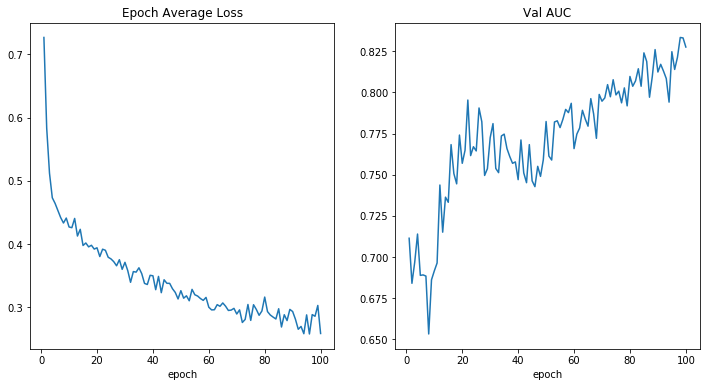

In [126]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [127]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "40best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [129]:
print(classification_report(
    y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7679    1.0000    0.8687        43
           1     1.0000    0.9058    0.9506       138

    accuracy                         0.9282       181
   macro avg     0.8839    0.9529    0.9096       181
weighted avg     0.9449    0.9282    0.9311       181



In [130]:
def make_sam_df(bh_folder):
    '''makes dataframe for breakhis dataset'''    
    dflist = []
    for root, dirs, files in os.walk(bh_folder):
        for name in files:
            relpath = os.path.relpath(root, bh_folder)
            ext = os.path.splitext(name)[-1]

            # get info from filename
            name_ = name.replace("T", "")
            name_ = name_.replace(".", "_") 
            if ext == '.jpg':
                try:
                    subject, ext = name_.split('_')
                    fullpath = os.path.join(root, name)
                    row = {'relpath':relpath, 'filename':name, 'subject':subject, 'fullpath':fullpath}
                    dflist.append(row)
                except:
                    pass
    df = pd.DataFrame(dflist)
    df['subject'] = df['subject'].astype(int)
    return df

In [131]:
sam_df=make_sam_df('/workspace/0728tot/Sample_images')

In [134]:
datadf = pd.read_csv('/workspace/0728tot/duvdata.csv')

In [136]:
label_df=datadf.drop(columns=['filename','slide_id','seq','fullpath','name','Subtype']).drop_duplicates().sort_values('relpath',ignore_index=True)

In [140]:
subj=label_df.relpath.to_list()

In [141]:
subjlist = [int(x.replace("S","")) for x in subj]

In [142]:
sam_df=sam_df[sam_df.subject.isin(subjlist)].sort_values('filename')

In [149]:
sam_df['Class']=label_df.Class.to_list()

In [233]:
# from andrewjong's implemention
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [238]:
splt = ['test']
tumortypes = ['M','B']
for s in splt:
    for t in tumortypes:
        shutil.rmtree(f'/workspace/0728tot/DUVbinaryclass/{s}/{t}', ignore_errors=True)
        os.makedirs(f'/workspace/0728tot/DUVbinaryclass/{s}/{t}')
for t in tumortypes:
    sam_df[sam_df.Class == t].apply(lambda x: shutil.copyfile(x.fullpath, f'/workspace/0728tot/DUVbinaryclass/test/{t}/{x.filename}'), axis = 1)
test_directory='/workspace/0728tot/DUVbinaryclass/test/'
# Load Data from folders
data = {
    'test': ImageFolderWithPaths(root=test_directory, transform=image_transforms['test'])
}

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
duv_test_loader = torch.utils.data.DataLoader(data['test'], batch_size=4)

In [ ]:

# iterate over data
for inputs, labels, paths in dataloader:
    # use the above variables freely
    print(inputs, labels, paths)

In [168]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [250]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "40best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in duv_test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())


In [251]:
print(classification_report(
    y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7059    0.5000    0.5854        24
           1     0.7209    0.8611    0.7848        36

    accuracy                         0.7167        60
   macro avg     0.7134    0.6806    0.6851        60
weighted avg     0.7149    0.7167    0.7050        60



In [185]:
from torchvision.utils import save_image
import torch
import torchvision

In [249]:
pathlist=[]
for test_data in duv_test_loader:
    i=0
    temp_path_list=[]
    test_images, test_labels = (
        test_data[0].to(device),
        test_data[1].to(device),
    )
    result = cam(x=(test_images),class_idx=test_labels)
    for path in test_data[2]:
        temp_path_list.append(path[-6:-4].replace("T",""))
    for image in result:
        save_image(image, '/workspace/0728tot/WSIGradCam/'+temp_path_list[i]+'gradcam.png')
        i=i+1

In [246]:
pathlist[0][-6:-4]

'11'

In [ ]:
for i, (images, labels) in enumerate(duv_test_loader, 0):
    sample_fname, _ = duv_test_loader.dataset.samples[i]
    predlist.append(sample_fname)


In [231]:
predlist

['/workspace/0728tot/DUVbinaryclass/test/B/T11.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T16.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T19.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T2.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T20.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T22.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T23.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T24.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T25.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T26.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T27.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T28.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T29.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T30.jpg',
 '/workspace/0728tot/DUVbinaryclass/test/B/T44.jpg']

In [171]:
for name, _ in model.named_modules(): print(name)



features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer1.layers.dropout
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer2.layers.dropout
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.no

In [172]:
from monai.visualize import GradCAM

In [217]:
cam = GradCAM(nn_module=model,target_layers="features.norm5")

In [ ]:
img = Image.open()

convert_tensor = transforms.ToTensor()

convert_tensor(img)

In [207]:
save_image(result, str(20)+'img1.png')